In [11]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm, truncnorm
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.functions import gaus

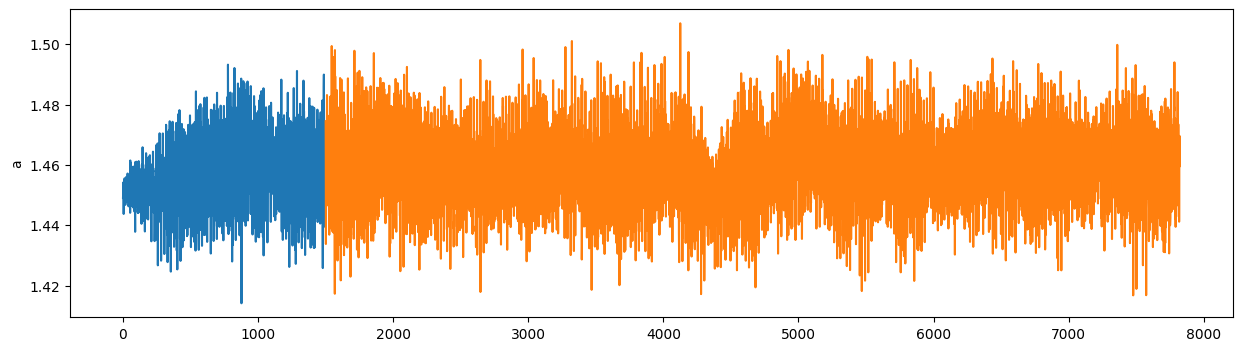

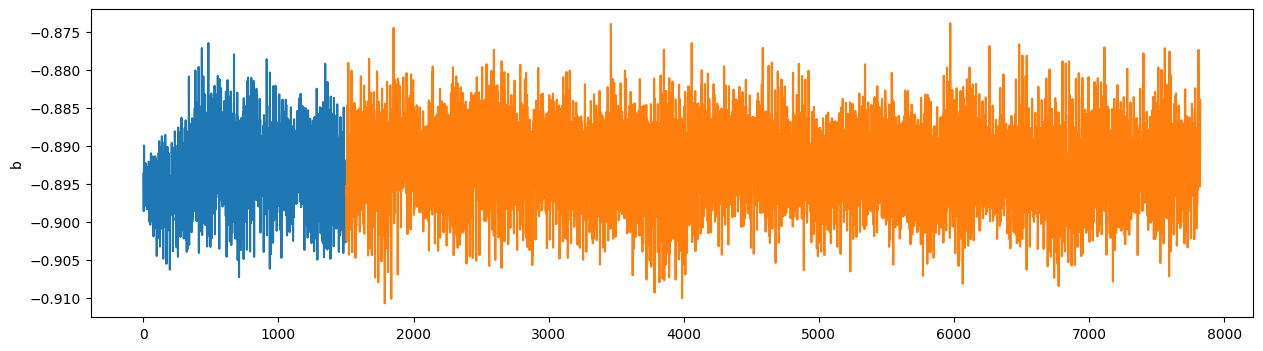

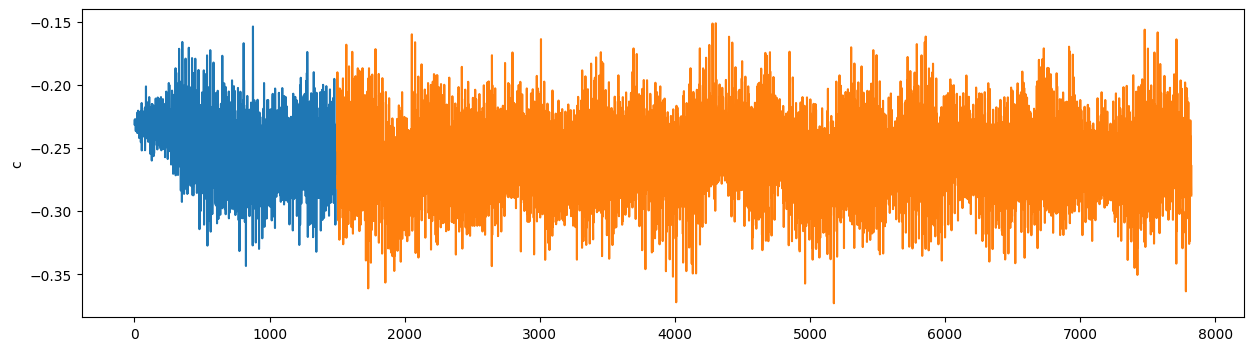

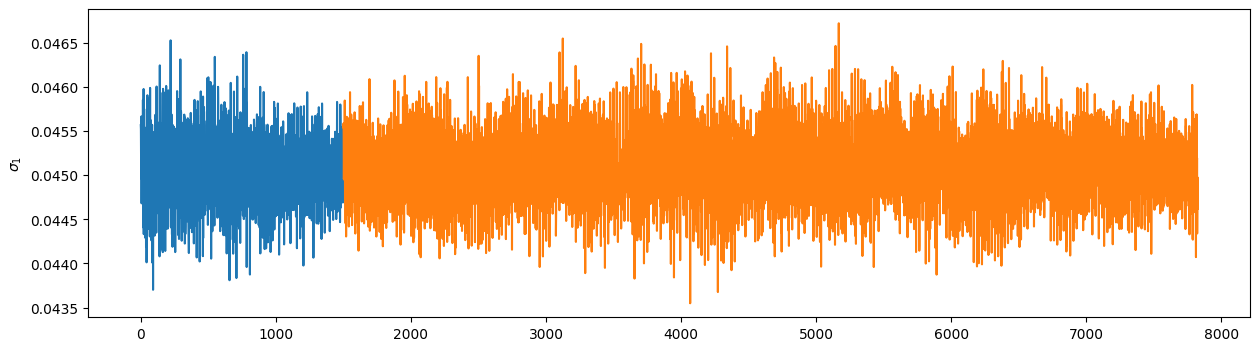

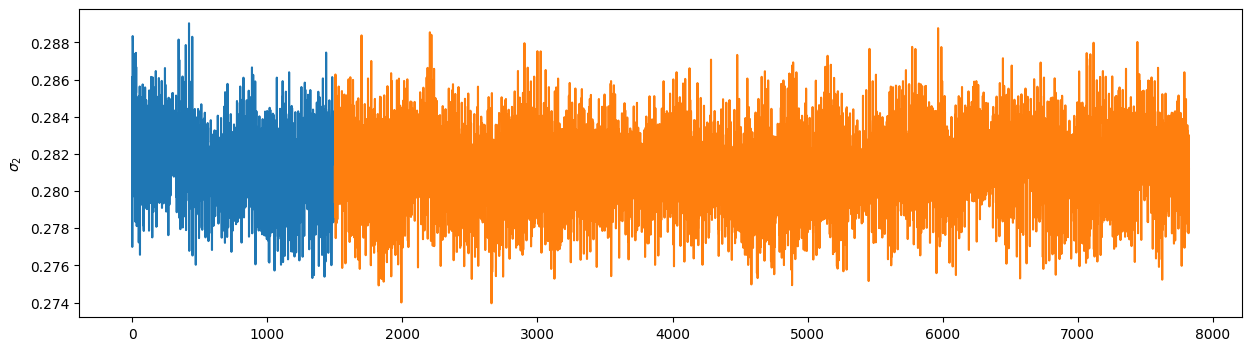

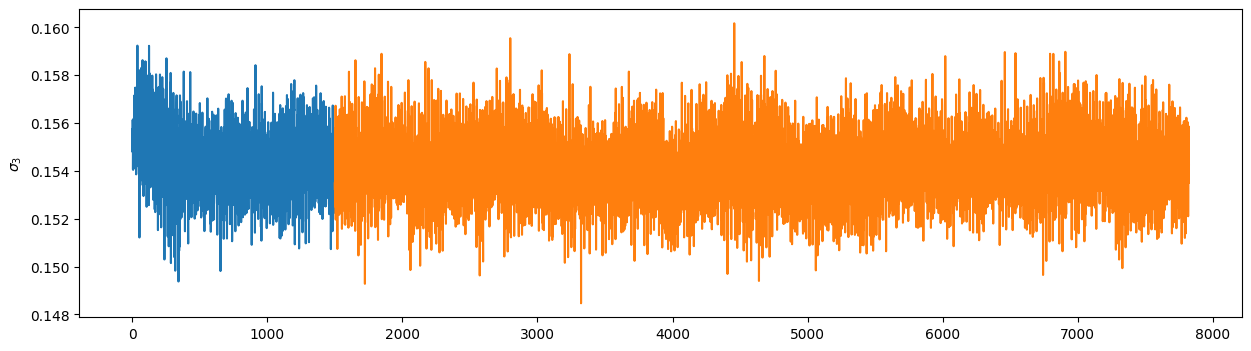

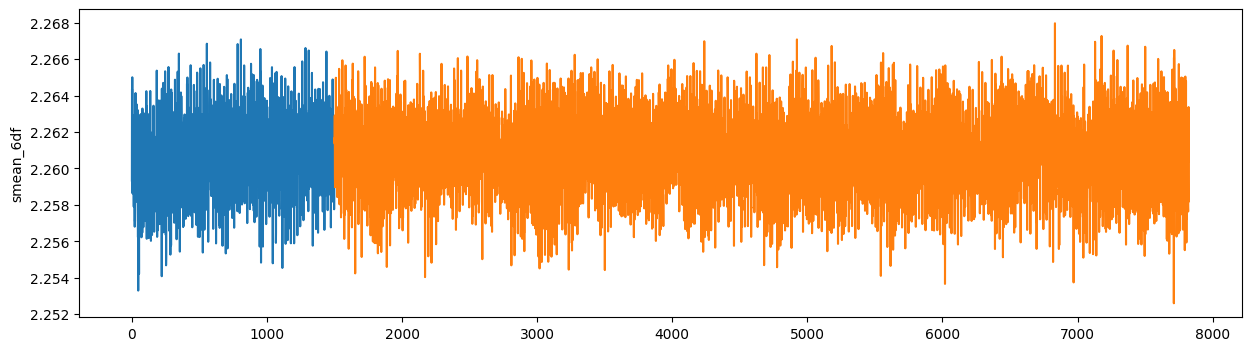

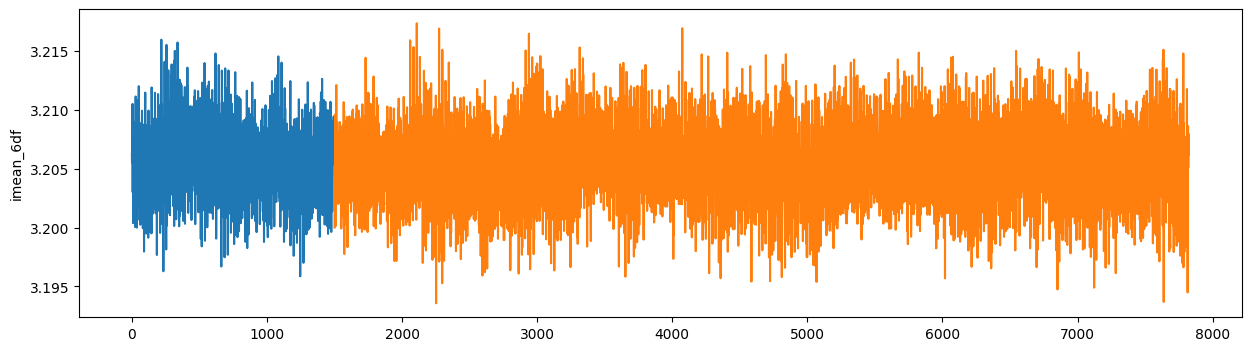

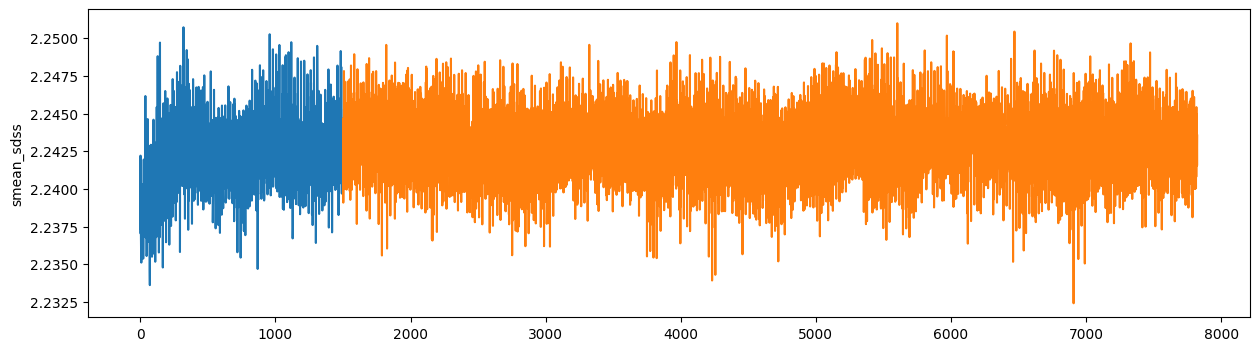

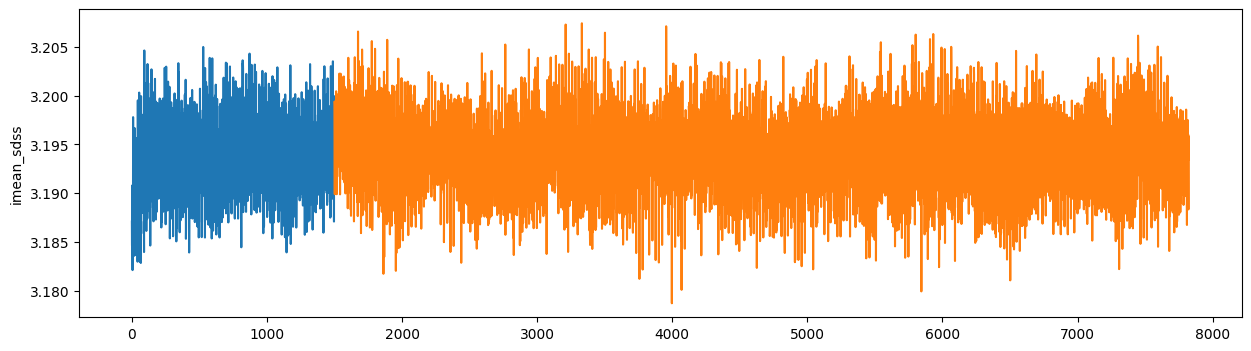

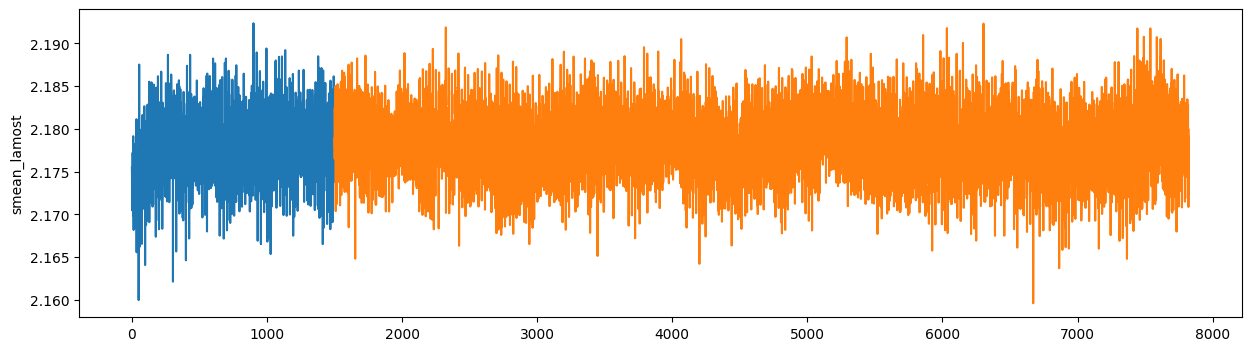

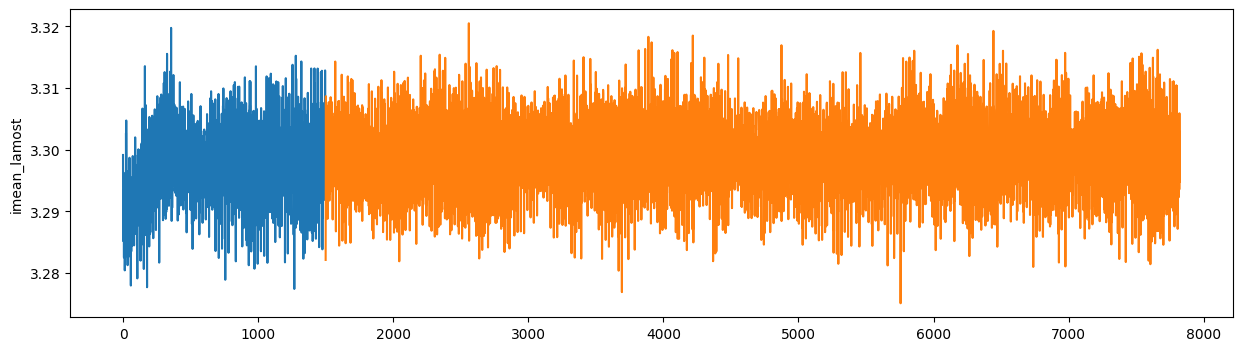

In [12]:
params = np.load("./chain.npy")

burn = 1500

param_names = [
    "a", "b", "c",
    r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$",
    "smean_6df", "imean_6df",
    "smean_sdss", "imean_sdss",
    "smean_lamost", "imean_lamost",
]

for param_no in range(12):
    # param_no = 2

    params_out = params[:(burn-1), :].T
    params_in = params[burn:, :].T

    param_in = params_in[param_no]
    param_out = params_out[param_no]

    plt.figure(figsize=(15, 4))
    plt.plot(list(range(0, burn-1)), param_out)
    plt.plot(list(range(burn, len(param_in) + burn)), param_in)
    plt.ylabel(param_names[param_no])

# Clean chain

In [13]:
burn_in = burn

params = np.load("./chain.npy")

params_clean = params[burn_in:, :]

np.save("./chain_clean.npy", params_clean)

# Save FP fits in CSV

In [14]:
params = np.load('./chain_clean.npy').T
# params = params[3200:, :].T
param_names = [
    "a", "b", "c",
    "smean_6df", "imean_6df", "sigma1_6df", "sigma2_6df", "sigma3_6df",
    "smean_sdss", "imean_sdss", "sigma1_sdss", "sigma2_sdss", "sigma3_sdss",
    "smean_lamost", "imean_lamost", "sigma1_lamost", "sigma2_lamost", "sigma3_lamost",
]

param_summary = []
for i in range(12):

    # Fit with Gaussian
    xdata = params[i]
    y, x_edges = np.histogram(xdata, bins=50, density=True)
    x = (x_edges[1:] + x_edges[:-1])/2
    popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])

    # Save mean and std
    mean_, std_ = popt

    param_summary.append(np.mean(xdata))

s1 = param_summary[3]
s2 = param_summary[4]
s3 = param_summary[5]

# Summary for each survey
param_6df = [param_summary[0], param_summary[1], param_summary[2], param_summary[6], param_summary[7], s1, s2, s3]
param_sdss = [param_summary[0], param_summary[1], param_summary[2], param_summary[8], param_summary[9], s1, s2, s3]
param_lamost = [param_summary[0], param_summary[1], param_summary[2], param_summary[10], param_summary[11], s1, s2, s3]

# Save as dataframe
col_names = ["a", "b", "c", "smean", "imean", "s1", "s2", "s3"]
param_all = [param_6df, param_sdss, param_lamost]
df = pd.DataFrame(param_all, index=["6dFGS", "SDSS", "LAMOST"], columns=col_names)

# Calculate rmean
df["rmean"] = df["c"] + df["a"] * df["smean"] + df["b"] * df["imean"]
df = df[["a", "b", "c", "rmean", "smean", "imean", "s1", "s2", "s3"]]

df.to_csv("./fp_fits.csv")